# Building a nanoGPT: From Bigram Language Model to Transformer Decoder

In this notebook, I created a GPT-like model, starting from a basic bigram language model and progressively incorporating advanced attention techniques.

Throughout this notebook, I will:
1. Implement a simple bigram language model to establish a baseline.
2. Gradually integrate more sophisticated attention techniques, including multi-head attention and positional encoding.
3. Compare the performance of our models at each stage to highlight the impact of these enhancements.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
with open('./input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Total unique characters:", vocab_size, end="\n\n")
print(chars)
print(''.join(chars))

Total unique characters: 65

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [ ]:
char_to_number = {ch:i for i,ch in enumerate(chars)}
number_to_char = {i:ch for i,ch in enumerate(chars)}

# encoder: take a string, output a list of integers
encode = lambda s: [char_to_number[c] for c in s]

# decoder: take a list of integers, output a string
decode = lambda l: ''.join([number_to_char[i] for i in l])

encoded_tokens = encode("make a transformer, only the decoder")
print(encoded_tokens)

decoded_tokens = decode(encoded_tokens)
print(decoded_tokens)

[51, 39, 49, 43, 1, 39, 1, 58, 56, 39, 52, 57, 44, 53, 56, 51, 43, 56, 6, 1, 53, 52, 50, 63, 1, 58, 46, 43, 1, 42, 43, 41, 53, 42, 43, 56]
make a transformer, only the decoder


##Making the data

In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])


torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [ ]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [ ]:
decode(train_data[:100].tolist())

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [ ]:
context_window = 8 #for now
sample_data = train_data[:context_window+1]
print(sample_data, decode(sample_data.tolist()), sep=" = ")

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58]) = First Cit


In [ ]:
x = train_data[:context_window] # except the `+1`th character
y = train_data[1:context_window+1] # except the very first `0`th character
for t in range(context_window):
    context = x[:t+1].tolist()
    target = y[t]
    print(f"When input is {context} the target: {target}")

When input is [18] the target: 47
When input is [18, 47] the target: 56
When input is [18, 47, 56] the target: 57
When input is [18, 47, 56, 57] the target: 58
When input is [18, 47, 56, 57, 58] the target: 1
When input is [18, 47, 56, 57, 58, 1] the target: 15
When input is [18, 47, 56, 57, 58, 1, 15] the target: 47
When input is [18, 47, 56, 57, 58, 1, 15, 47] the target: 58


In [ ]:
for t in range(context_window):
    context = x[:t+1].tolist()
    target = y[t].tolist()
    print(f"{decode(context)} → {decode([target])}")

F → i
Fi → r
Fir → s
Firs → t
First →  
First  → C
First C → i
First Ci → t


##Making a basic Bigram Linear Model with softmax, then adding the decoder part later on

In [ ]:
torch.manual_seed(42)

batch_size = 32       # n_samples or b
block_size = 8        # context_window or t
max_iters = 20_000    # total steps
eval_interval = 1_000 # loss prnting
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32


In [ ]:
device

'cpu'

In [ ]:
class BigramLM(nn.Module):


    def __init__(self):
        super().__init__()
        self.embedding_table = nn.Embedding(vocab_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):

        tok_emb = self.embedding_table(idx) # B, T, n_emb
        logits = self.lm_head(tok_emb) # B, T, vocab_size

        if targets is None:
            loss=None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


    def generate(self, idx, max_new_tokens):

        for _ in range(max_new_tokens):
            logits, loss = self(idx)

            # last token (8th in the context window)
            # and use its distribution to get the next token
            logits = logits[:, -1, :]

            #logits into probability
            probs = F.softmax(logits, dim=-1) ## along the last dimension , here 1

            # Take the next idx
            next_idx = torch.multinomial(probs, num_samples=1)

            # Append
            idx = torch.cat((idx, next_idx), dim=1)

        return idx

In [ ]:
model = BigramLM()

### 🗽 Transfer to device 🗽 ###
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
print(model)

BigramLM(
  (embedding_table): Embedding(65, 32)
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)


##Get Batch

In [ ]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    ### 🗽 Transfer to device 🗽 ###
    x, y = x.to(device), y.to(device)
    return x, y

## Esmtimating Loss

In [ ]:
@torch.no_grad()
def estimate_loss():
    '''
    This function takes the random samples from the dataset (based on the batch size)
    for `eval_iter` times. Records loss and takes the mean loss. And reports back.

    Which means, if we have the `eval_iter = 10` and `batch_size=32` then it will take
    32 random samples from training data and then validation data for 10 times and takes
    the means of these 10 losses.
    '''
    out = {}

    # sets on evaluation mode
    model.eval()

    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()

    # sets the model to training mode back!
    model.train()
    return out

In [ ]:
for step in range(max_iters):

  if step % eval_interval == 0:
      losses = estimate_loss()
      print(f"[Step {step}]: Train Loss~{losses['train']:.4f}, Val Loss~{losses['val']:.4f}")



  xb, yb = get_batch('train')


  logits, loss = model(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

[Step 0]: Train Loss~4.3626, Val Loss~4.3557
[Step 1000]: Train Loss~2.5696, Val Loss~2.5975
[Step 2000]: Train Loss~2.5166, Val Loss~2.5170
[Step 3000]: Train Loss~2.4737, Val Loss~2.5073
[Step 4000]: Train Loss~2.4794, Val Loss~2.5044
[Step 5000]: Train Loss~2.4757, Val Loss~2.5001
[Step 6000]: Train Loss~2.4645, Val Loss~2.4901
[Step 7000]: Train Loss~2.4735, Val Loss~2.4858
[Step 8000]: Train Loss~2.4675, Val Loss~2.4912
[Step 9000]: Train Loss~2.4642, Val Loss~2.4982
[Step 10000]: Train Loss~2.4732, Val Loss~2.4883
[Step 11000]: Train Loss~2.4629, Val Loss~2.4922
[Step 12000]: Train Loss~2.4702, Val Loss~2.4894
[Step 13000]: Train Loss~2.4547, Val Loss~2.4945
[Step 14000]: Train Loss~2.4695, Val Loss~2.4891
[Step 15000]: Train Loss~2.4593, Val Loss~2.4914
[Step 16000]: Train Loss~2.4685, Val Loss~2.4826
[Step 17000]: Train Loss~2.4723, Val Loss~2.4910
[Step 18000]: Train Loss~2.4595, Val Loss~2.4898
[Step 19000]: Train Loss~2.4651, Val Loss~2.4864


## Result

In [ ]:
model.generate(
    idx = torch.zeros((1,1), dtype = torch.long,device = device),
    max_new_tokens = 500,
).shape

torch.Size([1, 501])

In [ ]:
output = decode(model.generate(
    idx = torch.zeros((1,1), dtype = torch.long,device = device),
    max_new_tokens = 500)[0].tolist()
)
print(output)


Thy, theinrdard whe he imeareg's wnd f Buras
Alaresowawe t:
Tor d!
ARG coutes, r,
Arby,
Longe stereeas meavellde dentset the t mbrs, s hechasllll athantct t darer r bridouasts
O wirenge ll weal pawayomyovell. aixf t iass th s n dre fau ITUSh htho wingean grll


Th fe an l's.
G jubas s, Cover me se thend E:
JO:
BAy ppard cince t, thigathuarovingnl?
O s t averutthieimyeatheerison mibld d mevealer mpeamounothirisomeOf y se het hes MI t my od me candethr. and hed t; s, bloof hay per, ts ns rt lot ks


###The model is giving an output but its mostly just gibberish
#Introducing attention meachanisms

###This is the architecture of a transforer from the famous "Attention is all you need"
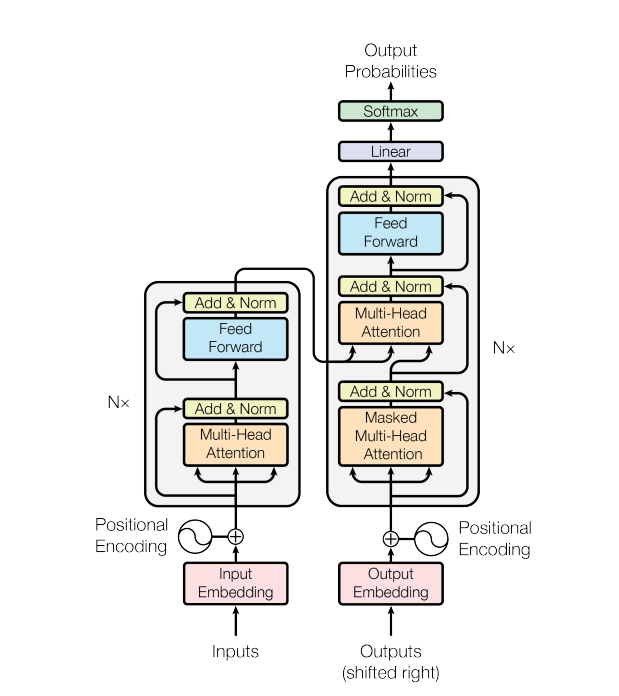

### but for making a gpt, I will just make the decoder part of this, because.. gpt doesn't care about input tokens, it looks at the past tokens and creates new tokens
so what we are gonna be making

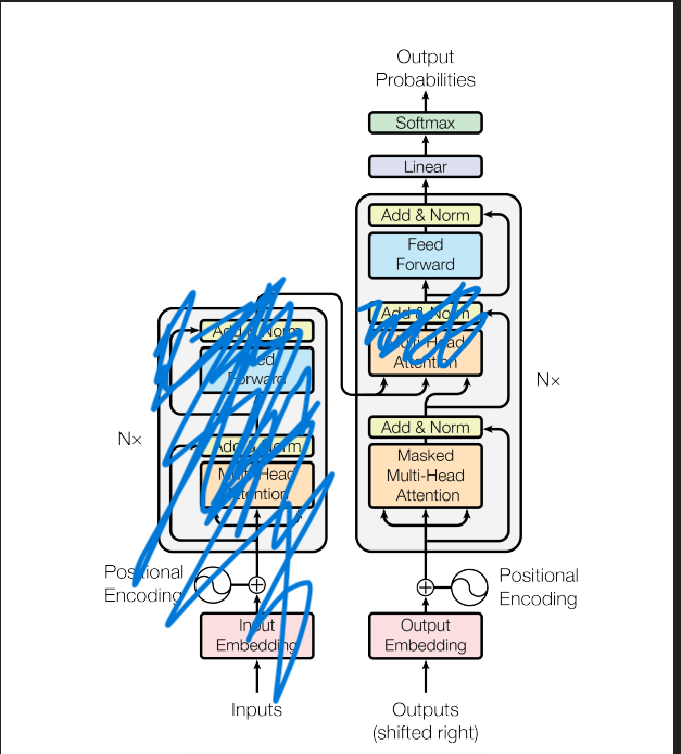




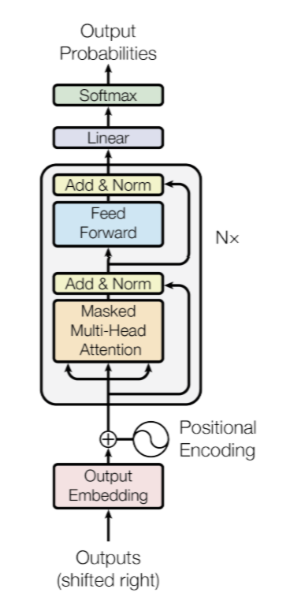

In [ ]:

batch_size = 32
block_size = 8
n_embd = 32

max_iters = 20_000
eval_interval = 1_000
eval_iters = 200
learning_rate = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

head_size = n_embd

In [ ]:
device


'cpu'

In [ ]:
class Head(nn.Module):
  # this class will create query, key and column tensors and also a registor buffer to mask the future tokens so they don't interact with the past tokens

  def __init__(self, head_size):
    super().__init__()
    self.query = nn.Linear(n_embd, head_size, bias = False)
    self.key = nn.Linear(n_embd, head_size, bias = False)
    self.value = nn.Linear(n_embd, head_size, bias = False)

    self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size, device = device)))

  def forward(self,x):
    # here te x input is the positions
    B,T,C = x.shape
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)

    wei = q @ k.transpose(-2,-1) * C**-0.05  # the C**-0.5 is used to control the variance
    wei = wei.masked_fill(self.tril[:T,:T] == 0, float("-inf"))
    wei = F.softmax(wei,dim = -1);
    out = wei@ v;

    return out





In [ ]:
class BigramLM(nn.Module):


  def __init__(self):
    super().__init__()
    self.embedding_table = nn.Embedding(vocab_size, n_embd)
    ## add position embeddings
    self.position_embeddings = nn.Embedding(block_size, n_embd)
    #seld attention_head
    self.sa_head = Head(head_size)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape

    tok_emb = self.embedding_table(idx) # B, T, n_emb
    pos_emb = self.position_embeddings(torch.arange(T, device = device))
    x = tok_emb + pos_emb
    x = self.sa_head(x)
    logits = self.lm_head(x) # B, T, vocab_size

    if targets is None:
        loss=None
    else:
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

    return logits, loss


  def generate(self, idx, max_new_tokens):



    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:] # I need to only have size of `T`
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :]

      probs = F.softmax(logits, dim=-1) ## along the last dimension  here 1

      next_idx = torch.multinomial(probs, num_samples=1)

      idx = torch.cat((idx, next_idx), dim=1)

    return idx

In [ ]:
xb, xb.shape

(tensor([[50,  1, 40, 43,  1, 46, 43, 56],
         [53, 42, 63,  1, 54, 39, 57, 57],
         [56, 43, 54, 53, 56, 58, 43, 42],
         [39, 60, 43,  1, 54, 39, 56, 42],
         [39, 57, 43,  1, 58, 53, 52, 45],
         [43, 52,  1, 58, 46, 43,  1, 42],
         [43, 57,  1, 51, 39, 63,  1, 57],
         [53,  1, 57, 46, 47, 52, 43, 57],
         [52,  1, 58, 46, 43,  1, 50, 47],
         [50,  1, 57, 58, 56, 47, 49, 47],
         [56, 50, 63,  1, 57, 58, 47, 56],
         [53, 59, 56, 57, 43, 50, 44,  1],
         [57, 39, 63,  1, 63, 53, 59,  6],
         [52, 45, 42, 53, 51,  1, 58, 53],
         [26, 33, 31, 10,  0, 32, 46, 39],
         [58, 46, 53, 59, 45, 46, 58,  1],
         [53, 57, 58, 10,  0, 28, 39, 56],
         [51, 47, 50, 47, 58, 63,  8,  0],
         [58, 46, 39, 52,  1, 51, 43, 12],
         [53, 53, 49,  5, 42,  1, 57, 53],
         [54, 56, 53, 59, 42,  1, 57, 58],
         [51, 39, 52, 63,  1, 57, 41, 53],
         [47, 58, 47, 53, 52,  6,  0, 32],
         [6

In [ ]:
xb[:, -block_size:]

tensor([[50,  1, 40, 43,  1, 46, 43, 56],
        [53, 42, 63,  1, 54, 39, 57, 57],
        [56, 43, 54, 53, 56, 58, 43, 42],
        [39, 60, 43,  1, 54, 39, 56, 42],
        [39, 57, 43,  1, 58, 53, 52, 45],
        [43, 52,  1, 58, 46, 43,  1, 42],
        [43, 57,  1, 51, 39, 63,  1, 57],
        [53,  1, 57, 46, 47, 52, 43, 57],
        [52,  1, 58, 46, 43,  1, 50, 47],
        [50,  1, 57, 58, 56, 47, 49, 47],
        [56, 50, 63,  1, 57, 58, 47, 56],
        [53, 59, 56, 57, 43, 50, 44,  1],
        [57, 39, 63,  1, 63, 53, 59,  6],
        [52, 45, 42, 53, 51,  1, 58, 53],
        [26, 33, 31, 10,  0, 32, 46, 39],
        [58, 46, 53, 59, 45, 46, 58,  1],
        [53, 57, 58, 10,  0, 28, 39, 56],
        [51, 47, 50, 47, 58, 63,  8,  0],
        [58, 46, 39, 52,  1, 51, 43, 12],
        [53, 53, 49,  5, 42,  1, 57, 53],
        [54, 56, 53, 59, 42,  1, 57, 58],
        [51, 39, 52, 63,  1, 57, 41, 53],
        [47, 58, 47, 53, 52,  6,  0, 32],
        [61, 39, 50, 50, 57,  1, 5

In [ ]:
xb[:, -block_size:].shape

torch.Size([32, 8])

###Now **TRAINING** the model with self attention(it will give a better result)

In [ ]:
model = BigramLM()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [ ]:
sum(len(i) for i in model.parameters())

363

In [ ]:
print(model)

BigramLM(
  (embedding_table): Embedding(65, 32)
  (position_embeddings): Embedding(8, 32)
  (sa_head): Head(
    (query): Linear(in_features=32, out_features=32, bias=False)
    (key): Linear(in_features=32, out_features=32, bias=True)
    (value): Linear(in_features=32, out_features=32, bias=True)
  )
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)


In [ ]:
for step in range(1,max_iters +1):
  if step%eval_interval == 0:
    losses = estimate_loss()
    print(f"Step {step} : Train loss : {losses['train']:.4f} and Val Loss: {losses['val'] :.4f}")

  xb,yb = get_batch('train')
  logits, loss = model(xb,yb)
  optimizer.zero_grad(set_to_none = True)
  loss.backward()
  optimizer.step()

Step 1000 : Train loss : 2.5525 and Val Loss: 2.5476
Step 2000 : Train loss : 2.4613 and Val Loss: 2.4637
Step 3000 : Train loss : 2.4229 and Val Loss: 2.4327
Step 4000 : Train loss : 2.4037 and Val Loss: 2.4227
Step 5000 : Train loss : 2.3976 and Val Loss: 2.4184
Step 6000 : Train loss : 2.3896 and Val Loss: 2.3951
Step 7000 : Train loss : 2.3739 and Val Loss: 2.4035
Step 8000 : Train loss : 2.3665 and Val Loss: 2.3940
Step 9000 : Train loss : 2.3725 and Val Loss: 2.3958
Step 10000 : Train loss : 2.3620 and Val Loss: 2.3789
Step 11000 : Train loss : 2.3606 and Val Loss: 2.3741
Step 12000 : Train loss : 2.3502 and Val Loss: 2.3795
Step 13000 : Train loss : 2.3492 and Val Loss: 2.3790
Step 14000 : Train loss : 2.3557 and Val Loss: 2.3782
Step 15000 : Train loss : 2.3494 and Val Loss: 2.3811
Step 16000 : Train loss : 2.3467 and Val Loss: 2.3762
Step 17000 : Train loss : 2.3364 and Val Loss: 2.3829
Step 18000 : Train loss : 2.3360 and Val Loss: 2.3671
Step 19000 : Train loss : 2.3229 and 

### Our loss has decreased, so lets now see the changes in the predicted text

In [ ]:
output = decode(
    model.generate(
        idx = torch.zeros((1,1),
        dtype = torch.long,
        device = device),
        max_new_tokens= 500
    )[0].tolist()
)
print(output)


An mof nd he ad winger: edd ovesto qeuey the st masucy hor, I beve whif bech I blos art emen tount tilonuk inotha t sin ot,
Antren bret Ya daishan came mesper,-
prns,
Torfsat ouse fitiny mu mercy irs igry Cothe waly.

Fooreve ter,
Musur bs Joces eme.

And tharnonout
I yet the tham ayre then kn cth
Ro I meet lled! sha r's phourmach te'l hady cowre:, we--what st he.

ARWMAULBESMERODORO:
Fioncer, in eat othel heeve Lekn sa my ist as wacke ndigroof foes wennnot ne. gtr hal ind at!

Bughhee halimm Be


Before:

Thy, theinrdard whe he imeareg's wnd f Buras
Alaresowawe t:
Tor d!
ARG coutes, r,
Arby,
Longe stereeas meavellde dentset the t mbrs, s hechasllll athantct t darer r bridouasts
O wirenge ll weal pawayomyovell. aixf t iass th s n dre fau ITUSh htho wingean grll


Th fe an l's.
G jubas s, Cover me se thend E:
JO:
BAy ppard cince t, thigathuarovingnl?
O s t averutthieimyeatheerison mibld d mevealer mpeamounothirisomeOf y se het hes MI t my od me candethr. and hed t; s, bloof hay per, ts ns rt lot ks

### It is better than before, now lets add on :

## Multihead attention

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self,num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

  def forward(self,x):
    return torch.cat([h(x) for h in self.heads], dim = -1)



In [ ]:
class BigramLM(nn.Module):


  def __init__(self):
    super().__init__()
    self.embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embeddings = nn.Embedding(block_size, n_embd)
    self.sa_heads = MultiHeadAttention(4, n_embd//4) # to make shape workout with the next layer
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape

    tok_emb = self.embedding_table(idx) # B, T, n_emb
    pos_emb = self.position_embeddings(torch.arange(T, device = device))
    x = tok_emb + pos_emb
    x = self.sa_heads(x)
    logits = self.lm_head(x) # B, T, vocab_size

    if targets is None:
        loss=None
    else:
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

    return logits, loss


  def generate(self, idx, max_new_tokens):



    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:] # i need to only have size of `T`
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :]

      probs = F.softmax(logits, dim=-1) ## along the last dimension  here 1

      next_idx = torch.multinomial(probs, num_samples=1)

      idx = torch.cat((idx, next_idx), dim=1)

    return idx

##Training again

In [ ]:
model = BigramLM()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)


In [ ]:
sum(len(i) for i in model.parameters())

363

In [ ]:
print(model)

BigramLM(
  (embedding_table): Embedding(65, 32)
  (position_embeddings): Embedding(8, 32)
  (sa_heads): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x Head(
        (query): Linear(in_features=32, out_features=8, bias=False)
        (key): Linear(in_features=32, out_features=8, bias=True)
        (value): Linear(in_features=32, out_features=8, bias=True)
      )
    )
  )
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)


In [ ]:
for step in range(1,max_iters +1):
  if step%eval_interval == 0:
    losses = estimate_loss()
    print(f"Step {step} : Train loss : {losses['train']:.4f} and Val Loss: {losses['val'] :.4f}")

  xb,yb = get_batch('train')
  logits, loss = model(xb,yb)
  optimizer.zero_grad(set_to_none = True)
  loss.backward()
  optimizer.step()

Step 1000 : Train loss : 2.4245 and Val Loss: 2.4271
Step 2000 : Train loss : 2.3430 and Val Loss: 2.3554
Step 3000 : Train loss : 2.2858 and Val Loss: 2.3100
Step 4000 : Train loss : 2.2686 and Val Loss: 2.2862
Step 5000 : Train loss : 2.2345 and Val Loss: 2.2759
Step 6000 : Train loss : 2.2264 and Val Loss: 2.2621
Step 7000 : Train loss : 2.2158 and Val Loss: 2.2304
Step 8000 : Train loss : 2.2105 and Val Loss: 2.2422
Step 9000 : Train loss : 2.1844 and Val Loss: 2.2247
Step 10000 : Train loss : 2.1769 and Val Loss: 2.2339
Step 11000 : Train loss : 2.1737 and Val Loss: 2.2113
Step 12000 : Train loss : 2.1691 and Val Loss: 2.1957
Step 13000 : Train loss : 2.1550 and Val Loss: 2.1963
Step 14000 : Train loss : 2.1404 and Val Loss: 2.2037
Step 15000 : Train loss : 2.1434 and Val Loss: 2.2055
Step 16000 : Train loss : 2.1461 and Val Loss: 2.1925
Step 17000 : Train loss : 2.1346 and Val Loss: 2.2020
Step 18000 : Train loss : 2.1355 and Val Loss: 2.1964
Step 19000 : Train loss : 2.1209 and 

### We see the loss is lesser than previous models

In [ ]:
output = decode(
    model.generate(
        idx = torch.zeros((1,1),
        dtype = torch.long,
        device = device),
        max_new_tokens= 500
    )[0].tolist()
)
print(output)


Whomake eagch arise ther you like ith some last.
KING chis wonn, dy we I no's the:
I by thather; als of the I amy hise;
Ang: thoous ken port yingch sarges lad. Fexe,
Whered you fwar dear fy mun dnower;
To's cray wich queth winsstat'd gracomack sidenr's uveer win ford.
Youctaruch? VI:
It rainge.

GLO:
Whe surn thallowhea
HARfI:
I'll rove the hal;
Come,
This tome's I say whave mustard; istardlyed out by butisss, and slinsiff sue?

APSRSANIOS: come,
Wess
Tur near sant ree grt thumboth; thath O re h


## Now let's add the feed forward layer

motivation of this layer:
we are predicting our output too fast, adding this will give our model the ability to catch on more complex patterns and also add some non linearity(by relu) in our model

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, n_embd),
        nn.ReLU()
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
class BigramLM(nn.Module):


  def __init__(self):
    super().__init__()
    self.embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embeddings = nn.Embedding(block_size, n_embd)
    self.sa_heads = MultiHeadAttention(4, n_embd//4)
    self.ffwd = FeedForward(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape

    tok_emb = self.embedding_table(idx) # B, T, n_emb
    pos_emb = self.position_embeddings(torch.arange(T, device = device))
    x = tok_emb + pos_emb
    x = self.sa_heads(x)
    logits = self.lm_head(x) # B, T, vocab_size

    if targets is None:
        loss=None
    else:
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

    return logits, loss


  def generate(self, idx, max_new_tokens):



    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :]

      probs = F.softmax(logits, dim=-1)

      next_idx = torch.multinomial(probs, num_samples=1)

      idx = torch.cat((idx, next_idx), dim=1)

    return idx

In [ ]:
model = BigramLM()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)


In [ ]:
sum(len(i) for i in model.parameters())

427

In [ ]:
print(model)

BigramLM(
  (embedding_table): Embedding(65, 32)
  (position_embeddings): Embedding(8, 32)
  (sa_heads): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x Head(
        (query): Linear(in_features=32, out_features=8, bias=False)
        (key): Linear(in_features=32, out_features=8, bias=True)
        (value): Linear(in_features=32, out_features=8, bias=True)
      )
    )
  )
  (ffwd): FeedForward(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)


In [ ]:
for step in range(1,max_iters +1):
  if step%eval_interval == 0:
    losses = estimate_loss()
    print(f"Step {step} : Train loss : {losses['train']:.4f} and Val Loss: {losses['val'] :.4f}")

  xb,yb = get_batch('train')
  logits, loss = model(xb,yb)
  optimizer.zero_grad(set_to_none = True)
  loss.backward()
  optimizer.step()

Step 1000 : Train loss : 2.4835 and Val Loss: 2.4911
Step 2000 : Train loss : 2.3675 and Val Loss: 2.3731
Step 3000 : Train loss : 2.2959 and Val Loss: 2.3135
Step 4000 : Train loss : 2.2636 and Val Loss: 2.2919
Step 5000 : Train loss : 2.2229 and Val Loss: 2.2554
Step 6000 : Train loss : 2.2268 and Val Loss: 2.2568
Step 7000 : Train loss : 2.1984 and Val Loss: 2.2460
Step 8000 : Train loss : 2.1753 and Val Loss: 2.2452
Step 9000 : Train loss : 2.1669 and Val Loss: 2.2321
Step 10000 : Train loss : 2.1669 and Val Loss: 2.2353
Step 11000 : Train loss : 2.1676 and Val Loss: 2.2232
Step 12000 : Train loss : 2.1491 and Val Loss: 2.2325
Step 13000 : Train loss : 2.1596 and Val Loss: 2.2089
Step 14000 : Train loss : 2.1635 and Val Loss: 2.2126
Step 15000 : Train loss : 2.1376 and Val Loss: 2.2146
Step 16000 : Train loss : 2.1575 and Val Loss: 2.2259
Step 17000 : Train loss : 2.1326 and Val Loss: 2.2129
Step 18000 : Train loss : 2.1382 and Val Loss: 2.2288
Step 19000 : Train loss : 2.1216 and 

In [ ]:
output = decode(
    model.generate(
        idx = torch.zeros((1,1),
        dtype = torch.long,
        device = device),
        max_new_tokens= 500
    )[0].tolist()
)
print(output)


PORY BOLYCUMENIUS:
Clar four, dond, ther thang waritfrow your done
There my strince and hilf ther the with yad to facks I'llavil brit one runt; be praby To quae you now!-vire, mon sonct, weevitin.
3tere den'll swith Ande igodllid is receas an'batl four pepprove
Haith.

bon.

Garn and yeram:
Sid'sprame and be eyt eart on, theret chamard in't he resst gect,
Avich ae blawill be willveak and vatay, Anknd rodes, hainoustct reton thours the fe lih remy sinces hip'd band luto det,
If:
Fored the son bal


##Now its time for the add & norm layer to finish our model

this cell will be dealing with a couple of problems here:

one is gradient vanishing and other is to match shapes, so i will also add some projection layers into our classes

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self,num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)#projcection layer

  def forward(self,x):
    out =  torch.cat([h(x) for h in self.heads], dim = -1)
    out = self.proj(out)
    return out

## add projection layer to feed forward

and n_embd * 4 because in the paper attention is all you need, it gives better results, so ...

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4*n_embd),
        nn.ReLU(),
        nn.Linear(4*n_embd, n_embd)# projection layer
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
class BigramLM(nn.Module):


  def __init__(self):
    super().__init__()
    self.embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embeddings = nn.Embedding(block_size, n_embd)
    self.sa_heads = MultiHeadAttention(4, n_embd//4)
    self.add_norm_1 = nn.LayerNorm(n_embd)
    self.ffwd = FeedForward(n_embd)
    self.add_norm_2 = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape

    tok_emb = self.embedding_table(idx) # B, T, n_emb
    pos_emb = self.position_embeddings(torch.arange(T, device = device))
    x = tok_emb + pos_emb
    #residual connections and add_norm
    x = x +  self.add_norm_1(self.sa_heads(x))
    x = x + self.add_norm_2(self.ffwd(x))
    logits = self.lm_head(x) # B, T, vocab_size

    if targets is None:
        loss=None
    else:
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

    return logits, loss


  def generate(self, idx, max_new_tokens):



    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :]

      probs = F.softmax(logits, dim=-1)

      next_idx = torch.multinomial(probs, num_samples=1)

      idx = torch.cat((idx, next_idx), dim=1)

    return idx

##Training again

In [ ]:
model = BigramLM()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [ ]:
sum(len(i) for i in model.parameters())

811

In [ ]:
print(model)

BigramLM(
  (embedding_table): Embedding(65, 32)
  (position_embeddings): Embedding(8, 32)
  (sa_heads): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x Head(
        (query): Linear(in_features=32, out_features=8, bias=False)
        (key): Linear(in_features=32, out_features=8, bias=False)
        (value): Linear(in_features=32, out_features=8, bias=False)
      )
    )
    (proj): Linear(in_features=32, out_features=32, bias=True)
  )
  (add_norm_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (ffwd): FeedForward(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (add_norm_2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)


In [ ]:
for step in range(1,max_iters +1):
  if step%eval_interval == 0:
    losses = estimate_loss()
    print(f"Step {step} : Train loss : {losses['train']:.4f} and Val Loss: {losses['val'] :.4f}")

  xb,yb = get_batch('train')
  logits, loss = model(xb,yb)
  optimizer.zero_grad(set_to_none = True)
  loss.backward()
  optimizer.step()

Step 1000 : Train loss : 2.3101 and Val Loss: 2.3284
Step 2000 : Train loss : 2.1910 and Val Loss: 2.2297
Step 3000 : Train loss : 2.1322 and Val Loss: 2.1849
Step 4000 : Train loss : 2.0939 and Val Loss: 2.1464
Step 5000 : Train loss : 2.0588 and Val Loss: 2.1199
Step 6000 : Train loss : 2.0268 and Val Loss: 2.1172
Step 7000 : Train loss : 2.0177 and Val Loss: 2.0935
Step 8000 : Train loss : 2.0119 and Val Loss: 2.0967
Step 9000 : Train loss : 1.9986 and Val Loss: 2.0888
Step 10000 : Train loss : 1.9830 and Val Loss: 2.0977
Step 11000 : Train loss : 1.9835 and Val Loss: 2.0724
Step 12000 : Train loss : 1.9715 and Val Loss: 2.0753
Step 13000 : Train loss : 1.9742 and Val Loss: 2.0848
Step 14000 : Train loss : 1.9579 and Val Loss: 2.0723
Step 15000 : Train loss : 1.9519 and Val Loss: 2.0563
Step 16000 : Train loss : 1.9512 and Val Loss: 2.0617
Step 17000 : Train loss : 1.9459 and Val Loss: 2.0678
Step 18000 : Train loss : 1.9399 and Val Loss: 2.0448
Step 19000 : Train loss : 1.9422 and 

In [ ]:
output = decode(
    model.generate(
        idx = torch.zeros((1,1),
        dtype = torch.long,
        device = device),
        max_new_tokens= 500
    )[0].tolist()
)
print(output)


As Pozer, hanks for my be speak isproves; Will hows which witurs seed forg:
He your stage scrung an in Pease us fall of no pitill tell, darch in ortren my beperiud a corr man's would are cecall much seed me kink! You, was are Rear heir the have so duper slames you ther witch his your garrie, which undent in unity lay matish.

CAPULET:
3

HENRY:
Now night proth thewerord, and
Henter.

SEN: bed.

BROF EDWARD EDWARD II:
Fik, I dight dust suesser?

SICarly sayt;
Of when zesings to Angrace the row pa


In [ ]:
### 2.05!! lesser loss 😃😃 but let' do more

#Now let's use multiple multiple attention heads or multiple blocks of multiple attention heads

In [ ]:
class Block(nn.Module):
  def __init__(self, n_embd, n_head):
    super().__init__()
    head_size = n_embd//n_head
    self.sa_heads = MultiHeadAttention(n_head, head_size) # to make shape workout with the next layer...
    self.add_norm_1 = nn.LayerNorm(n_embd)
    self.ffwd = FeedForward(n_embd)
    self.add_norm_2 = nn.LayerNorm(n_embd)


  def forward(self, x):

    x = x + self.add_norm_1(self.sa_heads(x))
    x = x + self.add_norm_2(self.ffwd(x))
    return x

In [ ]:

class BigramLM(nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embeddings = nn.Embedding(block_size, n_embd)
    #self attention_head
                      # self.sa_heads = MultiHeadAttention(4, n_embd//4)
                      # self.add_norm_1 = nn.LayerNorm(n_embd)
                      # self.ffwd = FeedForward(n_embd)
                      # self.add_norm_2 = nn.LayerNorm(n_embd)
    self.blocks = nn.Sequential(
        Block(n_embd,n_head = 4),
        Block(n_embd,n_head = 4),
        Block(n_embd,n_head = 4),
        nn.LayerNorm(n_embd)
    )
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape

    tok_emb = self.embedding_table(idx) # B, T, n_emb
    pos_emb = self.position_embeddings(torch.arange(T, device = device))
    x = tok_emb + pos_emb
          #residual connections and add_norm
          # x = x +  self.add_norm_1(self.sa_heads(x))
          # x = x + self.add_norm_2(self.ffwd(x))
    x = self.blocks(x)
    logits = self.lm_head(x) # B, T, vocab_size

    if targets is None:
        loss=None
    else:
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

    return logits, loss


  def generate(self, idx, max_new_tokens):



    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :]

      probs = F.softmax(logits, dim=-1)

      next_idx = torch.multinomial(probs, num_samples=1)

      idx = torch.cat((idx, next_idx), dim=1)

    return idx

## Training final,

In [ ]:
model = BigramLM()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [ ]:
sum(len(i) for i in model.parameters())

2091

In [ ]:
print(model)

BigramLM(
  (embedding_table): Embedding(65, 32)
  (position_embeddings): Embedding(8, 32)
  (blocks): Sequential(
    (0): Block(
      (sa_heads): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (query): Linear(in_features=32, out_features=8, bias=False)
            (key): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_features=8, bias=False)
          )
        )
        (proj): Linear(in_features=32, out_features=32, bias=True)
      )
      (add_norm_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
      )
      (add_norm_2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (1): Block(
      (sa_heads): MultiHeadAttention(
        (heads): ModuleList(
 

In [ ]:
for step in range(1,max_iters +1):
  if step%eval_interval == 0:
    losses = estimate_loss()
    print(f"Step {step} : Train loss : {losses['train']:.4f} and Val Loss: {losses['val'] :.4f}")

  xb,yb = get_batch('train')
  logits, loss = model(xb,yb)
  optimizer.zero_grad(set_to_none = True)
  loss.backward()
  optimizer.step()

Step 1000 : Train loss : 2.2586 and Val Loss: 2.2695
Step 2000 : Train loss : 2.1116 and Val Loss: 2.1477
Step 3000 : Train loss : 2.0427 and Val Loss: 2.1005
Step 4000 : Train loss : 1.9883 and Val Loss: 2.0785
Step 5000 : Train loss : 1.9657 and Val Loss: 2.0718
Step 6000 : Train loss : 1.9426 and Val Loss: 2.0503
Step 7000 : Train loss : 1.9305 and Val Loss: 2.0461
Step 8000 : Train loss : 1.9034 and Val Loss: 2.0347
Step 9000 : Train loss : 1.8929 and Val Loss: 2.0425
Step 10000 : Train loss : 1.8754 and Val Loss: 2.0370
Step 11000 : Train loss : 1.8710 and Val Loss: 2.0196
Step 12000 : Train loss : 1.8676 and Val Loss: 1.9970
Step 13000 : Train loss : 1.8571 and Val Loss: 1.9965
Step 14000 : Train loss : 1.8534 and Val Loss: 1.9960
Step 15000 : Train loss : 1.8549 and Val Loss: 1.9817
Step 16000 : Train loss : 1.8445 and Val Loss: 1.9886
Step 17000 : Train loss : 1.8414 and Val Loss: 1.9816
Step 18000 : Train loss : 1.8365 and Val Loss: 1.9770
Step 19000 : Train loss : 1.8291 and 

In [ ]:
output = decode(
    model.generate(
        idx = torch.zeros((1,1),
        dtype = torch.long,
        device = device),
        max_new_tokens= 500
    )[0].tolist()
)
print(output)


The have
Mosinedren's seem
the his prove a why, tilloved therefess a forshst, brough:
Corlo. Thy some, hast bhost there deace?

Froy what commened's teblencer'd sof.

RIV:
Not;
Stand, jogbleting morthing of the press be by an thus come.

RICHMOM:
But it honop!
For in.

AUTON Yond, trest farry me accoudess,
Is sweak a
doness of capest-betrach; any not communted tropine abaff'd their man:
But clager, sitts, bet me, bush that then leaveop, not haven uaren, and powell;
Our him
As notrenent: and drow


# wow! loss is 1.98  and the text produced is significantly better than from where we started🤩

#### now the final model is also in a separate notebook in this same repository with parameters taken from the paper coz I don't have enough computational power for Grid search CV kind of thing, check it out